In [41]:
#cloud check
import platform
import os

print("Running on:", platform.uname())
print("User:", os.getlogin())
print("Python path:", os.__file__)


Running on: uname_result(system='Darwin', node='Mac.fritz.box', release='24.3.0', version='Darwin Kernel Version 24.3.0: Thu Jan  2 20:23:36 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8112', machine='arm64')
User: root
Python path: /opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/os.py


In [42]:
!python3 -V

Python 3.10.18


In [43]:
import pickle

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [98]:
import mlflow
from mlflow import pyfunc
from sklearn.pipeline import make_pipeline
from mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_trip_duration_experiment")

<Experiment: artifact_location='/Users/jordanharris/Code/mlops_zoomcamp/mlruns/1', creation_time=1751031231135, experiment_id='1', last_update_time=1751031231135, lifecycle_stage='active', name='nyc_taxi_trip_duration_experiment', tags={}>

In [46]:
import os
print(os.getcwd())

#df = pd.read_parquet('/home/azureuser/j_harr/data/green_tripdata_2021-01.parquet')
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

/Users/jordanharris/Code/mlops_zoomcamp


In [47]:
df['duration'] = pd.to_datetime(df.lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
df.duration = df['duration'].apply(lambda x: x.total_seconds() / 60)

In [48]:
td =  df.duration.iloc[0]
td

np.float64(3.933333333333333)

In [49]:
#df[df.trip_type == 2]


/var/folders/_r/_94p_t6s1933ynymfxl25_7h0000gn/T/ipykernel_10403/4187696625.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

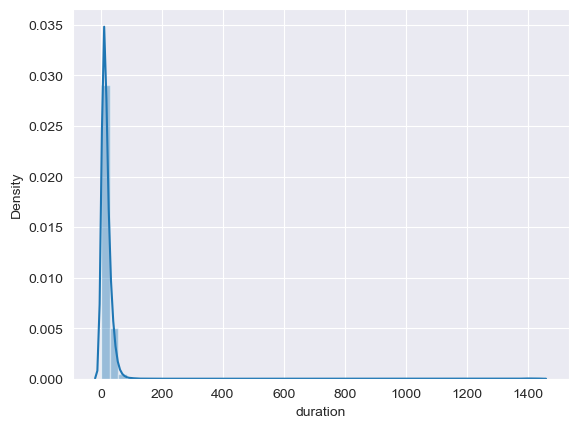

In [50]:
sns.distplot(df.duration)

In [51]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [52]:
#small filtering
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [53]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [54]:
#df[categorical].astype(str).dtypes
df[categorical] = df[categorical].astype(str)
#df.dtypes
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [55]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [56]:
#print(dv.feature_names_)
print(X_train.shape)
target = 'duration'
y_train = df[target].values
print(y_train.shape)


(73908, 507)
(73908,)


/var/folders/_r/_94p_t6s1933ynymfxl25_7h0000gn/T/ipykernel_10403/1518544609.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/_r/_94p_t6s1933ynymfxl25_7h0000gn/T/ipykernel_10403/1518544609.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

MSE: 96.577
RMSE: 9.827
MAE: 7.224
R²: 0.278


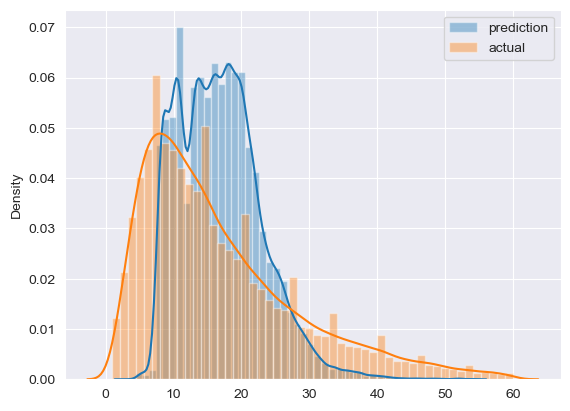

In [57]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

#------------------------------------------------------

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

In [58]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = pd.to_datetime(df.lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
    df.duration = df['duration'].apply(lambda x: x.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    #numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [59]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')


In [60]:
len(df_train), len(df_val)

(73908, 61921)

In [61]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [62]:
categorical = ['PU_DO']  #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [63]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [81]:
with mlflow.start_run(run_name="linear_regression"):

    mlflow.set_tag("model_type", "linear_regression")
    mlflow.set_tag("developer", "ja_harr")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    ln = LinearRegression()
    ln.fit(X_train, y_train)

    y_pred = ln.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"MSE: {mse:.3f}")
    print(f"Root MSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R²", r2)


    ln_pipeline = make_pipeline(dv, ln)
    signature = infer_signature(X_train, y_train)
    #input_example = train_dicts[:5]

    mlflow.sklearn.log_model(
            sk_model=ln_pipeline,
            name="linear_model",
            signature=signature,
            #input_example=input_example,
            registered_model_name="linear_regression"  # optional, auto-register in the MLflow Model Registry
        )


MSE: 60.198
Root MSE: 7.759
MAE: 5.340
R²: 0.594


Registered model 'linear_regression' already exists. Creating a new version of this model...
Created version '5' of model 'linear_regression'.


In [75]:
#with open('models/lin_reg.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)

Registered model 'linear_regression' already exists. Creating a new version of this model...
Created version '4' of model 'linear_regression'.


In [82]:
with mlflow.start_run(run_name="lasso_regression"):
    mlflow.set_tag("model_type", "lasso_regression")
    mlflow.set_tag("developer", "ja_harr")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    l = Lasso(alpha=alpha)
    l.fit(X_train, y_train)

    y_pred = l.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"MSE: {mse:.3f}")
    print(f"Root MSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R²", r2)


    lasso_pipeline = make_pipeline(dv, l)
    signature = infer_signature(X_train, y_train)
    #input_example = train_dicts[:5]

    mlflow.sklearn.log_model(
            sk_model=lasso_pipeline,
            name="lasso_model",
            signature=signature,
            #input_example=input_example,
            registered_model_name="lasso_regression"  # optional, auto-register in the MLflow Model Registry
        )

MSE: 124.708
Root MSE: 11.167
MAE: 8.218
R²: 0.158


Registered model 'lasso_regression' already exists. Creating a new version of this model...
Created version '3' of model 'lasso_regression'.


In [77]:
#with open('models/lasso.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)


Registered model 'lasso_regression' already exists. Creating a new version of this model...
Created version '2' of model 'lasso_regression'.


In [83]:
with mlflow.start_run(run_name="ridge_regression"):
    mlflow.set_tag("model_type", "ridge_regression")
    mlflow.set_tag("developer", "ja_harr")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    r = Ridge(alpha=alpha)
    r.fit(X_train, y_train)

    y_pred = r.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"MSE: {mse:.3f}")
    print(f"Root MSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R²", r2)


    ridge_pipeline = make_pipeline(dv, r)
    signature = infer_signature(X_train, y_train)
    #input_example = train_dicts[:5]


    #example_df = df_val[categorical + numerical].iloc[:5]
    #preds = pipeline.predict(example_df)
    #signature = infer_signature(example_df, preds)

    mlflow.sklearn.log_model(
            sk_model=ridge_pipeline,
            name="ridge_model",
            signature=signature,
            #input_example=input_example,
            registered_model_name="ridge_regression"  # optional, auto-register in the MLflow Model Registry
    )

    #mlflow.log_artifact(local_path="models/ridge.bin", #artifact_path="models_pickle")

MSE: 56.414
Root MSE: 7.511
MAE: 5.068
R²: 0.619


Registered model 'ridge_regression' already exists. Creating a new version of this model...
Created version '10' of model 'ridge_regression'.


In [80]:
#with open('models/ridge.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)
#mlflow.log_artifact(local_path="models/ridge.bin", #artifact_path="models_pickle")
#Purpose

#A low‐level API for uploading any file you like (logs, plots, custom binary blobs, pickles, etc.) into the run’s artifact store.

#It does not wrap it in a standardized “MLmodel” directory or register it—it just copies the file.



Registered model 'ridge_regression' already exists. Creating a new version of this model...
Created version '9' of model 'ridge_regression'.


In [84]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [93]:
import sklearn, sys
print("sklearn version:", sklearn.__version__)
print("python executable:", sys.executable)

sklearn version: 1.7.0
python executable: /opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/bin/python


In [85]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [95]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("R²", r2)

    return {'loss': rmse, 'status': STATUS_OK}

In [96]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) - [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}
#The ranges in which we want hyperopt to explore the hyperparameters
#https://hyperopt.github.io/hyperopt/getting-started/search_spaces/

best_result = fmin(
    fn=objective, #fmin will try to optimize the given objective by minimizing the output
    space=search_space,
    algo=tpe.suggest, #algorithm to run the optimization
    max_evals=50,
    trials=Trials()# informatiuon for each run stored in tirals
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:33:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.42236                           
[1]	validation-rmse:6.82782                           
[2]	validation-rmse:6.72522                           
[3]	validation-rmse:6.69489                           
[4]	validation-rmse:6.67764                           
[5]	validation-rmse:6.67334                           
[6]	validation-rmse:6.66864                           
[7]	validation-rmse:6.66574                           
[8]	validation-rmse:6.66188                           
[9]	validation-rmse:6.65987                           
[10]	validation-rmse:6.65756                          
[11]	validation-rmse:6.65707                          
[12]	validation-rmse:6.65615                          
[13]	validation-rmse:6.65455                          
[14]	validation-rmse:6.65428                          
[15]	validation-rmse:6.65280                          
[16]	validation-rmse:6.65021                          
[17]	validation-rmse:6.65048                          
[18]	valid

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:33:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.28478                                                    
[1]	validation-rmse:7.10495                                                    
[2]	validation-rmse:6.76773                                                    
[3]	validation-rmse:6.65735                                                    
[4]	validation-rmse:6.61747                                                    
[5]	validation-rmse:6.60312                                                    
[6]	validation-rmse:6.59098                                                    
[7]	validation-rmse:6.58432                                                    
[8]	validation-rmse:6.57938                                                    
[9]	validation-rmse:6.57384                                                    
[10]	validation-rmse:6.57024                                                   
[11]	validation-rmse:6.56431                                                   
[12]	validation-rmse:6.56090            

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.33747                                                   
[1]	validation-rmse:10.58544                                                   
[2]	validation-rmse:9.94308                                                    
[3]	validation-rmse:9.39638                                                    
[4]	validation-rmse:8.93301                                                    
[5]	validation-rmse:8.54296                                                    
[6]	validation-rmse:8.21567                                                    
[7]	validation-rmse:7.94231                                                    
[8]	validation-rmse:7.71217                                                    
[9]	validation-rmse:7.52246                                                    
[10]	validation-rmse:7.36489                                                   
[11]	validation-rmse:7.23395                                                   
[12]	validation-rmse:7.12533            

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:38:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.76351                                                       
[1]	validation-rmse:6.70077                                                       
[2]	validation-rmse:6.68417                                                       
[3]	validation-rmse:6.68182                                                       
[4]	validation-rmse:6.67352                                                       
[5]	validation-rmse:6.66118                                                       
[6]	validation-rmse:6.65560                                                       
[7]	validation-rmse:6.64403                                                       
[8]	validation-rmse:6.63761                                                       
[9]	validation-rmse:6.63179                                                       
[10]	validation-rmse:6.62722                                                      
[11]	validation-rmse:6.62520                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:38:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.16457                                                     
[1]	validation-rmse:10.29872                                                     
[2]	validation-rmse:9.58819                                                      
[3]	validation-rmse:9.01093                                                      
[4]	validation-rmse:8.54496                                                      
[5]	validation-rmse:8.17062                                                      
[6]	validation-rmse:7.87176                                                      
[7]	validation-rmse:7.63286                                                      
[8]	validation-rmse:7.44348                                                      
[9]	validation-rmse:7.29363                                                      
[10]	validation-rmse:7.17466                                                     
[11]	validation-rmse:7.08096                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.66679                                                       
[1]	validation-rmse:7.35183                                                       
[2]	validation-rmse:6.89975                                                       
[3]	validation-rmse:6.72633                                                       
[4]	validation-rmse:6.65425                                                       
[5]	validation-rmse:6.62368                                                       
[6]	validation-rmse:6.60142                                                       
[7]	validation-rmse:6.59116                                                       
[8]	validation-rmse:6.58234                                                       
[9]	validation-rmse:6.57740                                                       
[10]	validation-rmse:6.57387                                                      
[11]	validation-rmse:6.57031                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.54754                                                       
[1]	validation-rmse:8.14047                                                       
[2]	validation-rmse:7.43717                                                       
[3]	validation-rmse:7.09218                                                       
[4]	validation-rmse:6.92167                                                       
[5]	validation-rmse:6.82996                                                       
[6]	validation-rmse:6.78221                                                       
[7]	validation-rmse:6.75605                                                       
[8]	validation-rmse:6.74111                                                       
[9]	validation-rmse:6.72959                                                       
[10]	validation-rmse:6.72187                                                      
[11]	validation-rmse:6.71732                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:44:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.37099                                                       
[1]	validation-rmse:7.23314                                                       
[2]	validation-rmse:6.91864                                                       
[3]	validation-rmse:6.82866                                                       
[4]	validation-rmse:6.79273                                                       
[5]	validation-rmse:6.77729                                                       
[6]	validation-rmse:6.77060                                                       
[7]	validation-rmse:6.76495                                                       
[8]	validation-rmse:6.75936                                                       
[9]	validation-rmse:6.75533                                                       
[10]	validation-rmse:6.75238                                                      
[11]	validation-rmse:6.74874                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.39902                                                      
[1]	validation-rmse:10.69476                                                      
[2]	validation-rmse:10.08897                                                      
[3]	validation-rmse:9.56922                                                       
[4]	validation-rmse:9.12554                                                       
[5]	validation-rmse:8.74875                                                       
[6]	validation-rmse:8.42932                                                       
[7]	validation-rmse:8.16002                                                       
[8]	validation-rmse:7.93380                                                       
[9]	validation-rmse:7.74308                                                       
[10]	validation-rmse:7.58375                                                      
[11]	validation-rmse:7.44954                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.74790                                                      
[1]	validation-rmse:11.31800                                                      
[2]	validation-rmse:10.92113                                                      
[3]	validation-rmse:10.55493                                                      
[4]	validation-rmse:10.21799                                                      
[5]	validation-rmse:9.90841                                                       
[6]	validation-rmse:9.62334                                                       
[7]	validation-rmse:9.36177                                                       
[8]	validation-rmse:9.12248                                                       
[9]	validation-rmse:8.90360                                                       
[10]	validation-rmse:8.70384                                                      
[11]	validation-rmse:8.52138                                                      
[12]

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.27109                                                        
[1]	validation-rmse:7.83136                                                        
[2]	validation-rmse:7.17049                                                        
[3]	validation-rmse:6.86897                                                        
[4]	validation-rmse:6.72482                                                        
[5]	validation-rmse:6.64853                                                        
[6]	validation-rmse:6.60431                                                        
[7]	validation-rmse:6.57975                                                        
[8]	validation-rmse:6.56300                                                        
[9]	validation-rmse:6.54411                                                        
[10]	validation-rmse:6.53146                                                       
[11]	validation-rmse:6.52428                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.19858                                                        
[1]	validation-rmse:7.10902                                                        
[2]	validation-rmse:6.82292                                                        
[3]	validation-rmse:6.74166                                                        
[4]	validation-rmse:6.71623                                                        
[5]	validation-rmse:6.70282                                                        
[6]	validation-rmse:6.69136                                                        
[7]	validation-rmse:6.68875                                                        
[8]	validation-rmse:6.68591                                                        
[9]	validation-rmse:6.67834                                                        
[10]	validation-rmse:6.67449                                                       
[11]	validation-rmse:6.66938                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.18867                                                     
[1]	validation-rmse:6.61856                                                     
[2]	validation-rmse:6.52606                                                     
[3]	validation-rmse:6.49829                                                     
[4]	validation-rmse:6.47825                                                     
[5]	validation-rmse:6.46657                                                     
[6]	validation-rmse:6.45692                                                     
[7]	validation-rmse:6.45159                                                     
[8]	validation-rmse:6.44357                                                     
[9]	validation-rmse:6.43888                                                     
[10]	validation-rmse:6.43383                                                    
[11]	validation-rmse:6.42865                                                    
[12]	validation-rmse:6.42305

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.39781                                                     
[1]	validation-rmse:6.79144                                                     
[2]	validation-rmse:6.69048                                                     
[3]	validation-rmse:6.66888                                                     
[4]	validation-rmse:6.65859                                                     
[5]	validation-rmse:6.65571                                                     
[6]	validation-rmse:6.64633                                                     
[7]	validation-rmse:6.64180                                                     
[8]	validation-rmse:6.63832                                                     
[9]	validation-rmse:6.63609                                                     
[10]	validation-rmse:6.63246                                                    
[11]	validation-rmse:6.63015                                                    
[12]	validation-rmse:6.62971

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.48479                                                     
[1]	validation-rmse:8.06396                                                     
[2]	validation-rmse:7.35114                                                     
[3]	validation-rmse:7.00788                                                     
[4]	validation-rmse:6.83574                                                     
[5]	validation-rmse:6.74330                                                     
[6]	validation-rmse:6.68966                                                     
[7]	validation-rmse:6.65883                                                     
[8]	validation-rmse:6.63882                                                     
[9]	validation-rmse:6.62718                                                     
[10]	validation-rmse:6.61721                                                    
[11]	validation-rmse:6.61158                                                    
[12]	validation-rmse:6.60742

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [18:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.80387                                                    
[1]	validation-rmse:11.42108                                                    
[2]	validation-rmse:11.06586                                                    
[3]	validation-rmse:10.73212                                                    
[4]	validation-rmse:10.42187                                                    
[5]	validation-rmse:10.13170                                                    
[6]	validation-rmse:9.86367                                                     
[7]	validation-rmse:9.61100                                                     
[8]	validation-rmse:9.38110                                                     
[9]	validation-rmse:9.16198                                                     
[10]	validation-rmse:8.96508                                                    
[11]	validation-rmse:8.77844                                                    
[12]	validation-rmse:8.60573

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:02:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.38766                                                       
[1]	validation-rmse:9.11922                                                        
[2]	validation-rmse:8.26144                                                        
[3]	validation-rmse:7.67980                                                        
[4]	validation-rmse:7.30628                                                        
[5]	validation-rmse:7.05969                                                        
[6]	validation-rmse:6.90529                                                        
[7]	validation-rmse:6.79379                                                        
[8]	validation-rmse:6.72291                                                        
[9]	validation-rmse:6.67180                                                        
[10]	validation-rmse:6.63843                                                       
[11]	validation-rmse:6.61187                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.34251                                                       
[1]	validation-rmse:10.59454                                                       
[2]	validation-rmse:9.95449                                                        
[3]	validation-rmse:9.40899                                                        
[4]	validation-rmse:8.94619                                                        
[5]	validation-rmse:8.55679                                                        
[6]	validation-rmse:8.22867                                                        
[7]	validation-rmse:7.95448                                                        
[8]	validation-rmse:7.72372                                                        
[9]	validation-rmse:7.53223                                                        
[10]	validation-rmse:7.37291                                                       
[11]	validation-rmse:7.24103                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:07:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.33624                                                        
[1]	validation-rmse:7.17840                                                        
[2]	validation-rmse:6.84832                                                        
[3]	validation-rmse:6.73592                                                        
[4]	validation-rmse:6.68824                                                        
[5]	validation-rmse:6.66528                                                        
[6]	validation-rmse:6.64955                                                        
[7]	validation-rmse:6.63926                                                        
[8]	validation-rmse:6.63456                                                        
[9]	validation-rmse:6.62646                                                        
[10]	validation-rmse:6.62464                                                       
[11]	validation-rmse:6.62134                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.81766                                                        
[1]	validation-rmse:6.61463                                                        
[2]	validation-rmse:6.56689                                                        
[3]	validation-rmse:6.55030                                                        
[4]	validation-rmse:6.52867                                                        
[5]	validation-rmse:6.52157                                                        
[6]	validation-rmse:6.51642                                                        
[7]	validation-rmse:6.51213                                                        
[8]	validation-rmse:6.50668                                                        
[9]	validation-rmse:6.49991                                                        
[10]	validation-rmse:6.49986                                                       
[11]	validation-rmse:6.49140                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.11023                                                    
[1]	validation-rmse:8.74015                                                     
[2]	validation-rmse:7.88023                                                     
[3]	validation-rmse:7.35033                                                     
[4]	validation-rmse:7.02401                                                     
[5]	validation-rmse:6.82748                                                     
[6]	validation-rmse:6.70452                                                     
[7]	validation-rmse:6.62519                                                     
[8]	validation-rmse:6.57376                                                     
[9]	validation-rmse:6.53832                                                     
[10]	validation-rmse:6.51070                                                    
[11]	validation-rmse:6.49246                                                    
[12]	validation-rmse:6.47816

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:09:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.30045                                                    
[1]	validation-rmse:8.99072                                                     
[2]	validation-rmse:8.11537                                                     
[3]	validation-rmse:7.54549                                                     
[4]	validation-rmse:7.17830                                                     
[5]	validation-rmse:6.94326                                                     
[6]	validation-rmse:6.79219                                                     
[7]	validation-rmse:6.68864                                                     
[8]	validation-rmse:6.62517                                                     
[9]	validation-rmse:6.57641                                                     
[10]	validation-rmse:6.54381                                                    
[11]	validation-rmse:6.51969                                                    
[12]	validation-rmse:6.50179

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.46977                                                    
[1]	validation-rmse:9.22479                                                     
[2]	validation-rmse:8.35814                                                     
[3]	validation-rmse:7.76244                                                     
[4]	validation-rmse:7.36058                                                     
[5]	validation-rmse:7.09129                                                     
[6]	validation-rmse:6.90938                                                     
[7]	validation-rmse:6.78808                                                     
[8]	validation-rmse:6.70240                                                     
[9]	validation-rmse:6.64099                                                     
[10]	validation-rmse:6.59692                                                    
[11]	validation-rmse:6.56560                                                    
[12]	validation-rmse:6.54131

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:12:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.38143                                                    
[1]	validation-rmse:9.10550                                                     
[2]	validation-rmse:8.23787                                                     
[3]	validation-rmse:7.65789                                                     
[4]	validation-rmse:7.28241                                                     
[5]	validation-rmse:7.03054                                                     
[6]	validation-rmse:6.86401                                                     
[7]	validation-rmse:6.75221                                                     
[8]	validation-rmse:6.67799                                                     
[9]	validation-rmse:6.62650                                                     
[10]	validation-rmse:6.58815                                                    
[11]	validation-rmse:6.56061                                                    
[12]	validation-rmse:6.53983

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:14:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.97136                                                     
[1]	validation-rmse:9.98244                                                      
[2]	validation-rmse:9.19873                                                      
[3]	validation-rmse:8.58912                                                      
[4]	validation-rmse:8.11586                                                      
[5]	validation-rmse:7.75202                                                      
[6]	validation-rmse:7.47049                                                      
[7]	validation-rmse:7.25675                                                      
[8]	validation-rmse:7.09290                                                      
[9]	validation-rmse:6.96718                                                      
[10]	validation-rmse:6.87031                                                     
[11]	validation-rmse:6.79368                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.93304                                                     
[1]	validation-rmse:9.92199                                                      
[2]	validation-rmse:9.12681                                                      
[3]	validation-rmse:8.51480                                                      
[4]	validation-rmse:8.04454                                                      
[5]	validation-rmse:7.68619                                                      
[6]	validation-rmse:7.41060                                                      
[7]	validation-rmse:7.20507                                                      
[8]	validation-rmse:7.04774                                                      
[9]	validation-rmse:6.92740                                                      
[10]	validation-rmse:6.83704                                                     
[11]	validation-rmse:6.76676                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:19:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.90392                                                     
[1]	validation-rmse:9.87642                                                      
[2]	validation-rmse:9.07429                                                      
[3]	validation-rmse:8.46058                                                      
[4]	validation-rmse:7.99272                                                      
[5]	validation-rmse:7.63860                                                      
[6]	validation-rmse:7.36950                                                      
[7]	validation-rmse:7.16925                                                      
[8]	validation-rmse:7.01782                                                      
[9]	validation-rmse:6.90156                                                      
[10]	validation-rmse:6.81681                                                     
[11]	validation-rmse:6.74945                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:21:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.59827                                                     
[1]	validation-rmse:11.04433                                                     
[2]	validation-rmse:10.54751                                                     
[3]	validation-rmse:10.10055                                                     
[4]	validation-rmse:9.70420                                                      
[5]	validation-rmse:9.34985                                                      
[6]	validation-rmse:9.03309                                                      
[7]	validation-rmse:8.75172                                                      
[8]	validation-rmse:8.50325                                                      
[9]	validation-rmse:8.28182                                                      
[10]	validation-rmse:8.08446                                                     
[11]	validation-rmse:7.91311                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:24:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.98924                                                     
[1]	validation-rmse:10.01366                                                     
[2]	validation-rmse:9.24045                                                      
[3]	validation-rmse:8.63865                                                      
[4]	validation-rmse:8.17072                                                      
[5]	validation-rmse:7.80781                                                      
[6]	validation-rmse:7.53250                                                      
[7]	validation-rmse:7.32093                                                      
[8]	validation-rmse:7.15784                                                      
[9]	validation-rmse:7.03329                                                      
[10]	validation-rmse:6.93684                                                     
[11]	validation-rmse:6.86102                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:26:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.58756                                                     
[1]	validation-rmse:11.02407                                                     
[2]	validation-rmse:10.51784                                                     
[3]	validation-rmse:10.06318                                                     
[4]	validation-rmse:9.65669                                                      
[5]	validation-rmse:9.29434                                                      
[6]	validation-rmse:8.97150                                                      
[7]	validation-rmse:8.68443                                                      
[8]	validation-rmse:8.42956                                                      
[9]	validation-rmse:8.20366                                                      
[10]	validation-rmse:8.00512                                                     
[11]	validation-rmse:7.82909                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:29:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.79330                                                     
[1]	validation-rmse:9.71116                                                      
[2]	validation-rmse:8.89246                                                      
[3]	validation-rmse:8.28878                                                      
[4]	validation-rmse:7.83888                                                      
[5]	validation-rmse:7.51276                                                      
[6]	validation-rmse:7.27908                                                      
[7]	validation-rmse:7.10497                                                      
[8]	validation-rmse:6.97481                                                      
[9]	validation-rmse:6.88107                                                      
[10]	validation-rmse:6.80812                                                     
[11]	validation-rmse:6.75637                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.55328                                                     
[1]	validation-rmse:10.96334                                                     
[2]	validation-rmse:10.43732                                                     
[3]	validation-rmse:9.96927                                                      
[4]	validation-rmse:9.55442                                                      
[5]	validation-rmse:9.18726                                                      
[6]	validation-rmse:8.86294                                                      
[7]	validation-rmse:8.57698                                                      
[8]	validation-rmse:8.32704                                                      
[9]	validation-rmse:8.10580                                                      
[10]	validation-rmse:7.91326                                                     
[11]	validation-rmse:7.74294                                                     
[12]	validation-

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.12838                                                       
[1]	validation-rmse:10.23762                                                       
[2]	validation-rmse:9.50999                                                        
[3]	validation-rmse:8.92229                                                        
[4]	validation-rmse:8.44720                                                        
[5]	validation-rmse:8.07118                                                        
[6]	validation-rmse:7.77116                                                        
[7]	validation-rmse:7.53289                                                        
[8]	validation-rmse:7.34622                                                        
[9]	validation-rmse:7.19802                                                        
[10]	validation-rmse:7.08115                                                       
[11]	validation-rmse:6.98905                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.91536                                                        
[1]	validation-rmse:8.50164                                                        
[2]	validation-rmse:7.66666                                                        
[3]	validation-rmse:7.18743                                                        
[4]	validation-rmse:6.91545                                                        
[5]	validation-rmse:6.75480                                                        
[6]	validation-rmse:6.65983                                                        
[7]	validation-rmse:6.59998                                                        
[8]	validation-rmse:6.56152                                                        
[9]	validation-rmse:6.53457                                                        
[10]	validation-rmse:6.51804                                                       
[11]	validation-rmse:6.50192                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:39:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.78578                                                       
[1]	validation-rmse:9.70117                                                        
[2]	validation-rmse:8.88457                                                        
[3]	validation-rmse:8.27944                                                        
[4]	validation-rmse:7.83641                                                        
[5]	validation-rmse:7.51105                                                        
[6]	validation-rmse:7.27713                                                        
[7]	validation-rmse:7.10806                                                        
[8]	validation-rmse:6.98136                                                        
[9]	validation-rmse:6.89022                                                        
[10]	validation-rmse:6.82097                                                       
[11]	validation-rmse:6.76676                                                

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.48088                                                       
[1]	validation-rmse:10.83541                                                       
[2]	validation-rmse:10.26865                                                       
[3]	validation-rmse:9.77382                                                        
[4]	validation-rmse:9.34114                                                        
[5]	validation-rmse:8.96294                                                        
[6]	validation-rmse:8.63773                                                        
[7]	validation-rmse:8.35318                                                        
[8]	validation-rmse:8.10928                                                        
[9]	validation-rmse:7.90105                                                        
[10]	validation-rmse:7.72011                                                       
[11]	validation-rmse:7.56329                                                


KeyboardInterrupt



In [ ]:
mlflow.xgboost.autolog(disable=True)

In [101]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R²", r2)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", name="preprocessor")

    mlflow.xgboost.log_model(booster, name="models_mlflow")

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2025/06/27 19:56:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/06/27 19:56:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [102]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("R²", r2)

/opt/homebrew/Caskroom/miniforge/base/envs/mlops_zoomcamp/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [108]:
run_id   = "c340236dba7c4903bdb8995e2bbebf9b"
artifact = "models_mlflow"   # <— the folder you just confirmed

model_uri = f"runs:/{run_id}/{artifact}"
pyfunc_model = mlflow.pyfunc.load_model(model_uri)

MlflowException: Failed to download artifacts from path 'models_mlflow', please ensure that the path is correct.

In [ ]:
loaded_model

In [107]:
run_id =  '9ae4346c55764400b2b5ee7a6cac56d2'
model_uri = f"runs:/{run_id}/models_mlflow"
booster = mlflow.xgboost.load_model(model_uri)

# now you can call booster.predict on a DMatrix
import xgboost as xgb
dm = xgb.DMatrix(X_val)               # or new data

In [109]:
y_pred = booster.predict(dm)
y_pred[:10]

array([14.782765 ,  7.184751 , 15.971323 , 24.328938 ,  9.559302 ,
       17.115105 , 11.6522455,  8.688133 ,  8.962229 , 18.982166 ],
      dtype=float32)